In [1]:
# Set the repository root as a working directory 
%cd ..

d:\MLOps\Hands_on\DVC\DVC


# Init DVC repository

1. Init DVC repository and setup DVC remote storage


```bash
dvc init
```

3. Add DVC repository under git control

```bash
git add .
git commit -m "Init DVC repo"
```

# View config

In [3]:
# Look on stages config 
# Read config
import pprint
import yaml

with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)

pprint.pprint(config)

{'base': {'log_level': 'INFO', 'random_state': 42},
 'data_load': {'dataset_csv': 'data/raw/iris.csv'},
 'data_split': {'test_size': 0.2,
                'testset_path': 'data/processed/test_iris.csv',
                'trainset_path': 'data/processed/train_iris.csv'},
 'evaluate': {'confusion_matrix_image': 'confusion_matrix.png',
              'metrics_file': 'metrics.json',
              'reports_dir': 'reports'},
 'featurize': {'features_path': 'data/processed/featured_iris.csv',
               'target_column': 'target'},
 'train': {'cv': 3,
           'estimator_name': 'logreg',
           'estimators': {'logreg': {'param_grid': {'C': [0.001],
                                                    'max_iter': [100],
                                                    'solver': ['lbfgs']}},
                          'svm': {'param_grid': {'C': [0.1, 1.0],
                                                 'degree': [3, 5],
                                                 'gamma': ['scale

# Create and run stages for a DVC pipeline

Create DVC pipeline using CLI

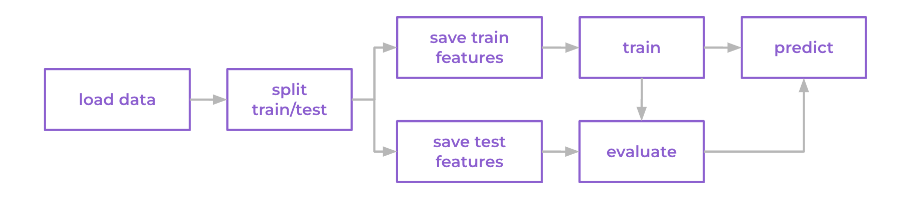

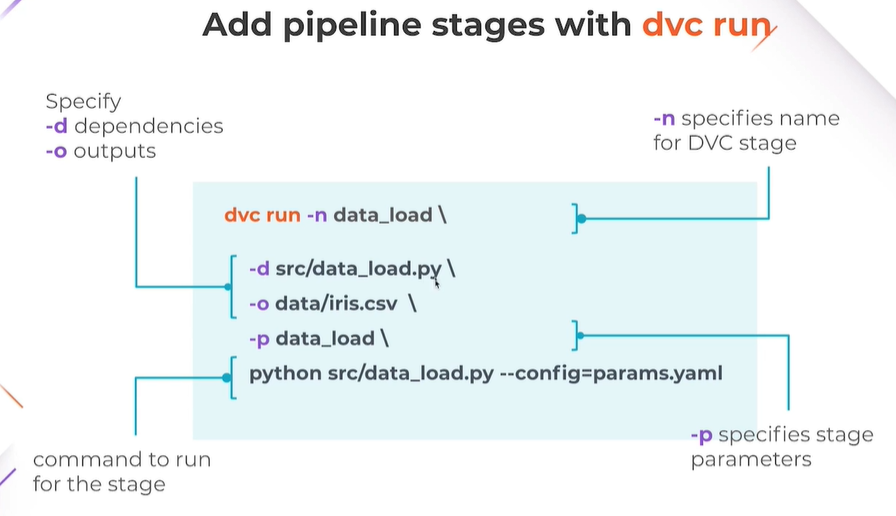

## Get data


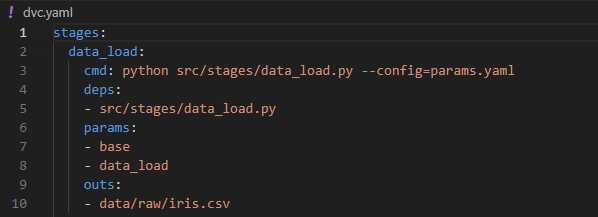

In [4]:
!dvc stage add -n data_load \
    -d src/stages/data_load.py \
    -o data/raw/iris.csv \
    -p base,data_load \
    python src/stages/data_load.py --config=params.yaml

Added stage 'data_load' in 'dvc.yaml'

To track the changes with git, run:

	git add dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true


## Featurization

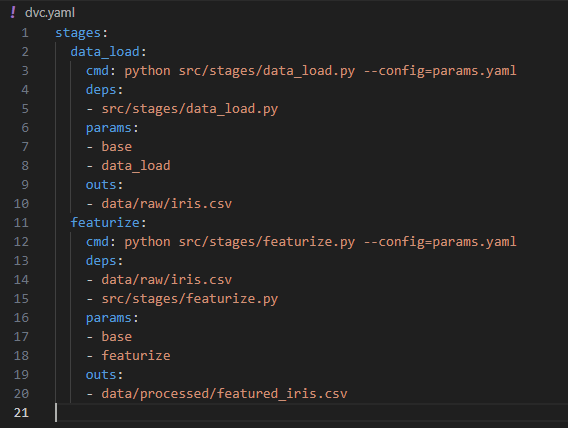

In [5]:
!dvc stage add -n featurize \
    -d src/stages/featurize.py \
    -d data/raw/iris.csv \
    -o data/processed/featured_iris.csv \
    -p base,featurize \
    python src/stages/featurize.py --config=params.yaml

Added stage 'featurize' in 'dvc.yaml'

To track the changes with git, run:

	git add dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true


## Split dataset into train/test  
- Using `dvc.yaml` editing 
- Copy/Paste lines below

```yaml
  data_split:
    cmd: python src/stages/data_split.py --config=params.yaml
    deps:
    - data/processed/featured_iris.csv
    - src/stages/data_split.py
    params:
    - base
    - data_split
    - featurize
    outs:
    - data/processed/test_iris.csv
    - data/processed/train_iris.csv
```

In [6]:
!dvc stage add -n data_split \
    -d src/stages/data_split.py \
    -d data/processed/featured_iris.csv \
    -o data/processed/test_iris.csv \
    -o data/processed/train_iris.csv \
    -p base,data_split,featurize \
    python src/stages/data_split.py --config=params.yaml

Added stage 'data_split' in 'dvc.yaml'

To track the changes with git, run:

	git add dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true


In [7]:
### Run current pipeline
!dvc repro

Stage 'data_load' didn't change, skipping
Stage 'featurize' didn't change, skipping
Stage 'data_split' is cached - skipping run, checking out outputs
Use `dvc push` to send your updates to remote storage.


## TODO 

- add DVC pipeline stage for `src/stages/train.py`
- add DVC pipeline stage for `src/stages/evaluate.py`

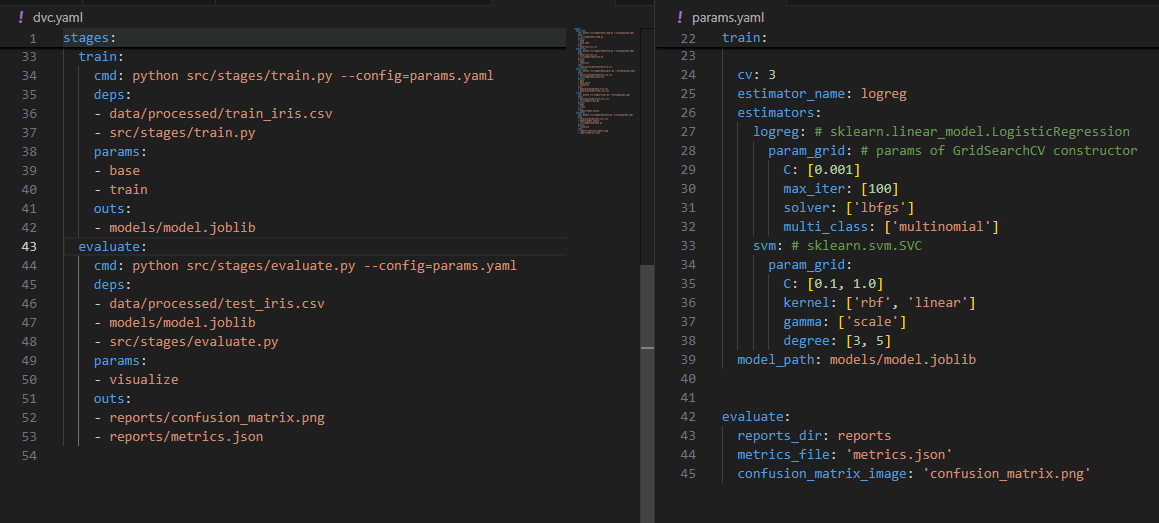

In [11]:
!dvc stage add -n train \
    -d src/stages/train.py \
    -d data/processed/train_iris.csv \
    -p base,train \
    -o models/model.joblib \
    python src/stages/train.py --config=params.yaml

!dvc stage add -n evaluate \
    -d src/stages/evaluate.py \
    -d models/model.joblib \
    -d data/processed/test_iris.csv \
    -d params.yaml \
    -o reports/metrics.json \
    -o reports/confusion_matrix.png \
    python src/stages/evaluate.py --config=params.yaml

Added stage 'train' in 'dvc.yaml'

To track the changes with git, run:

	git add dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true
Added stage 'evaluate' in 'dvc.yaml'

To track the changes with git, run:

	git add dvc.yaml 'reports\.gitignore'

To enable auto staging, run:

	dvc config core.autostage true


## Run pipeline



In [12]:
!dvc repro

Stage 'data_load' didn't change, skipping
Stage 'featurize' didn't change, skipping
Stage 'data_split' didn't change, skipping
Stage 'train' didn't change, skipping
Running stage 'evaluate':
> python src/stages/evaluate.py --config=params.yaml
2024-10-11 09:34:19,253 — EVALUATE — INFO — Load model
2024-10-11 09:34:19,301 — EVALUATE — INFO — Load test dataset
2024-10-11 09:34:19,304 — EVALUATE — INFO — Evaluate (build report)
2024-10-11 09:34:19,307 — EVALUATE — INFO — Save metrics
2024-10-11 09:34:19,307 — EVALUATE — INFO — F1 metrics file saved to : reports\metrics.json
2024-10-11 09:34:19,308 — EVALUATE — INFO — Save confusion matrix
2024-10-11 09:34:19,857 — EVALUATE — INFO — Confusion matrix saved to : reports\confusion_matrix.png
Updating lock file 'dvc.lock'

To track the changes with git, run:

	git add dvc.lock

To enable auto staging, run:

	dvc config core.autostage true
Use `dvc push` to send your updates to remote storage.


In [15]:
## Run single pipeline
!dvc repro train


Stage 'data_load' didn't change, skipping
Stage 'featurize' didn't change, skipping
Stage 'data_split' didn't change, skipping
Stage 'train' didn't change, skipping
Data and pipelines are up to date.


# Reproduce pipeline

Use `-f` to forced reproducing of pipeline

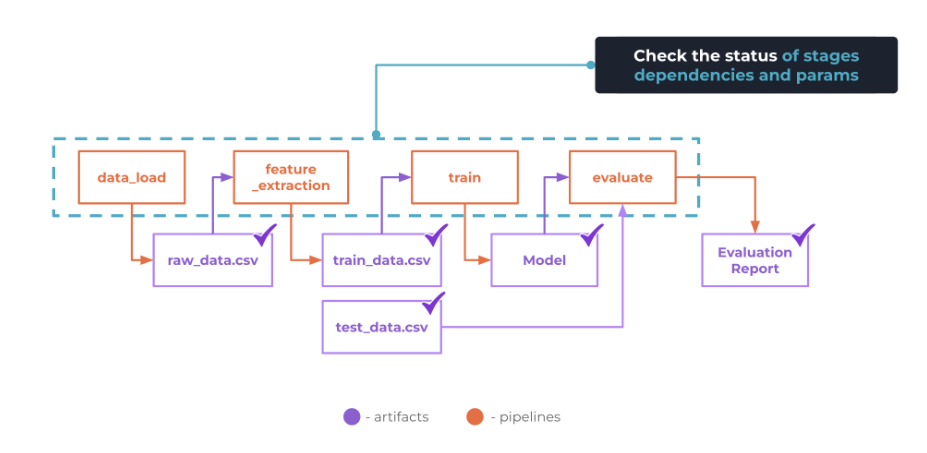


In [18]:
!dvc dag
!dvc dag --md >> figs/dag.md

        +-----------+     
        | data_load |     
        +-----------+     
              *           
              *           
              *           
        +-----------+     
        | featurize |     
        +-----------+     
              *           
              *           
              *           
        +------------+    
        | data_split |    
        +------------+    
         **        **     
       **            *    
      *               **  
+-------+               * 
| train |             **  
+-------+            *    
         **        **     
           **    **       
             *  *         
        +----------+      
        | evaluate |      
        +----------+      


In [13]:
!dvc repro -f

Running stage 'data_load':
> python src/stages/data_load.py --config=params.yaml
2024-10-11 09:35:04,126 — DATA_LOAD — INFO — Get dataset
2024-10-11 09:35:04,133 — DATA_LOAD — INFO — Save raw data

Running stage 'featurize':
> python src/stages/featurize.py --config=params.yaml
2024-10-11 09:35:05,167 — FEATURIZE — INFO — Load raw data
2024-10-11 09:35:05,171 — FEATURIZE — INFO — Extract features
2024-10-11 09:35:05,175 — FEATURIZE — INFO — Save features

Running stage 'data_split':
> python src/stages/data_split.py --config=params.yaml
2024-10-11 09:35:06,827 — DATA_SPLIT — INFO — Load features
2024-10-11 09:35:06,829 — DATA_SPLIT — INFO — Split features into train and test sets
2024-10-11 09:35:06,830 — DATA_SPLIT — INFO — Save train and test sets

Running stage 'train':
> python src/stages/train.py --config=params.yaml
2024-10-11 09:35:08,686 — TRAIN — INFO — Get estimator name
2024-10-11 09:35:08,686 — TRAIN — INFO — Estimator: logreg
2024-10-11 09:35:08,686 — TRAIN — INFO — Load t

# Commit code changes & pipeline
```bash
git add .
git commit -m "Create DVC pipeline"
```
